# Conjoint Analysis of Crime Severity

[Andy Wheeler](mailto:apwheele@gmail.com)

This example uses a survey that asked folks to assign scores to different crime scenarios. It is very old, conducted in 1977 (in part by the well known Marvin Wolfgang) as a supplement to the then National Crime Survey (now known as the NCVS -- victim survey).

The data is available [at ICPSR](https://www.icpsr.umich.edu/icpsrweb/NACJD/studies/8295/datadocumentation). In another script I parsed the data to be in the usual wide format. This script loads that csv file to conduct subsequent analysis.

In [1]:
'''
Reading in the data for conjoint
analysis of the crime scores
'''

import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

##################
import matplotlib.pyplot as plt
import matplotlib

#My Theme
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'figure.dpi': 100}
 
matplotlib.rcParams.update(andy_theme)
##################

#Location of the dataset
data_loc = r'C:\Users\andre\Dropbox\Documents\BLOG\Conjoint_Survey\Conjoint_Analysis'
os.chdir(data_loc)

#Reading in as all strings
ncs = pd.read_csv('NSCS_Supplement.csv',dtype='str')
print( ncs.shape )

#I only need these columns for analysis
rank_vars = ['ID','Version_NSCS'] + ['R1_BikeTheft','R2_Robbery','R3_Truancy','R4_Stabs']
rank_vars += ['R' + str(i) for i in range(5,26)] #these change over the surveys
subset_data = ncs[rank_vars]

#Selecting out only version 1 surveys
print( ncs['Version_NSCS'].value_counts() ) #Blank here are surveys entirely not completed
subset_data = subset_data[ subset_data['Version_NSCS'] == "01" ]

#Doing nicer rank names, all except for the bomb 25 question 
#will be different for different versions
new_names = ['R5_Kidnap',
             'R6_PriceFix',
             'R7_Steal10',
             'R8_RobGun',
             'R9_Conceal',
             'R10_Bribe',
             'R11_Dice',
             'R12_Homicide',
             'R13_StealPainting',
             'R14_Rape',
             'R15_Threaten',
             'R16_Marijuana',
             'R17_BreakDisplay',
             'R18_Perjury',
             'R19_RobForce',
             'R20_Arson',
             'R21_DumpWaste',
             'R22_OrderCrime',
             'R23_Steal1000',
             'R24_DomesticAssault',
             'R25_Bomb']
rep_dict = {}
for old,new in zip(rank_vars[6:], new_names):
    rep_dict[old] = new

subset_data.rename(columns=rep_dict, inplace=True)
rank_li = rank_vars[2:6] + new_names

#Now getting rid of data that has missing data values
missing_vars = ((subset_data[ rank_li ] == "777777") |  (subset_data[ rank_li ] == "888888") | (subset_data[ rank_li ] == "      ")).sum(axis=1)
print( missing_vars.value_counts() ) #almost 700 totally blank, then another 500 partially missing
subset_data = subset_data[ missing_vars == 0 ]

#Now can convert all of these rank columns to numeric
for r in rank_li:
    subset_data[r] = pd.to_numeric(subset_data[r])

    
subset_data.describe()

(69540, 155)
      10225
01     5358
02     5305
03     5212
04     5149
05     5044
06     4977
07     4895
08     4859
09     4773
10     4683
11     4596
12     4464
Name: Version_NSCS, dtype: int64
0     4139
25     676
1      300
2       87
3       40
5       22
4       16
6       10
19       8
20       7
15       6
9        6
17       6
13       5
7        5
24       5
18       4
16       4
8        4
10       3
12       2
14       1
21       1
11       1
dtype: int64


,R1_BikeTheft,R2_Robbery,R3_Truancy,R4_Stabs,R5_Kidnap,R6_PriceFix,R7_Steal10,R8_RobGun,R9_Conceal,R10_Bribe,...,R16_Marijuana,R17_BreakDisplay,R18_Perjury,R19_RobForce,R20_Arson,R21_DumpWaste,R22_OrderCrime,R23_Steal1000,R24_DomesticAssault,R25_Bomb
count,4139.0,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,...,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000
mean,10.0,1368.953129,262.157284,53324.255859,29496.379560,9522.568495,971.325441,15309.414351,7568.944189,14747.592414,...,4349.961343,5139.343561,11288.570911,13754.902150,24601.208504,24508.841508,18489.300314,6287.783281,22573.996859,75224.089152
std,0.0,32138.126103,15544.164155,218549.697635,159238.429974,85779.152745,28016.121436,109727.193171,73488.916340,106653.214774,...,59182.057253,58211.418940,91161.171633,102738.042661,134306.451205,138891.653661,118230.276625,65606.808399,134957.739197,248294.145116
min,10.0,1.000000,1.000000,5.000000,5.000000,1.000000,1.000000,5.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
25%,10.0,50.000000,1.000000,200.000000,100.000000,75.000000,10.000000,100.000000,60.000000,100.000000,...,5.000000,90.000000,100.000000,100.000000,130.000000,100.000000,100.000000,90.000000,100.000000,200.000000
50%,10.0,100.000000,5.000000,500.000000,500.000000,200.000000,20.000000,300.000000,150.000000,250.000000,...,40.000000,200.000000,200.000000,250.000000,500.000000,400.000000,300.000000,200.000000,300.000000,1000.000000
75%,10.0,200.000000,10.000000,1000.000000,1000.000000,500.000000,100.000000,900.000000,500.000000,800.000000,...,100.000000,500.000000,500.000000,800.000000,1000.000000,1000.000000,1000.000000,500.000000,1000.000000,5000.000000
max,10.0,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,...,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000


In [2]:
#Creating the ranked scores

#Lets check out those 999999 scores
print( (subset_data[ rank_li ] == 999999).sum(axis=1).value_counts() )
#No one did max values across the board (24 999999), so will keep those cases

#Rank across rows
ranks = subset_data[ rank_li ].rank(axis=1)

#Now doing the mean for each variable rank
ranks.mean(axis=0)

0     3815
1       75
3       65
4       48
2       30
5       28
8       17
6       14
7        8
10       7
12       6
11       5
15       4
13       4
9        4
17       3
14       2
19       2
20       1
21       1
dtype: int64


R1_BikeTheft            3.177700
R2_Robbery              8.504228
R3_Truancy              2.247040
R4_Stabs               19.756101
R5_Kidnap              17.207417
R6_PriceFix            11.861319
R7_Steal10              5.140010
R8_RobGun              15.659942
R9_Conceal             10.962310
R10_Bribe              14.688935
R11_Dice                3.492993
R12_Homicide           20.520657
R13_StealPainting      12.198115
R14_Rape               19.439478
R15_Threaten           10.687243
R16_Marijuana           6.447813
R17_BreakDisplay       11.933559
R18_Perjury            13.451438
R19_RobForce           14.769268
R20_Arson              18.514738
R21_DumpWaste          16.487920
R22_OrderCrime         16.350205
R23_Steal1000          12.402392
R24_DomesticAssault    16.229645
R25_Bomb               22.869534
dtype: float64

In [3]:
#To do regression analysis, need to reshape to long format
ranks['ID'] = subset_data['ID']
long_ranks = pd.melt(ranks, 'ID', rank_li , 'Crime', 'Rank')

#Making a frequency weight to change the degrees of freedom
long_ranks['weights'] = 1/25

#Now can run the regression analysis, no intercept needed
form = 'Rank ~ Crime -1'
mod = smf.glm(formula=form, data=long_ranks, freq_weights=long_ranks['weights'], family=sm.families.Gaussian())
res = mod.fit()

print( res.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Rank   No. Observations:               103475
Model:                            GLM   Df Residuals:                  4114.00
Model Family:                Gaussian   Df Model:                           24
Link Function:               identity   Scale:                          17.515
Method:                          IRLS   Log-Likelihood:                -11785.
Date:                Fri, 22 May 2020   Deviance:                       72055.
Time:                        08:50:09   Pearson chi2:                 7.21e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Crime[R10_Bribe]    

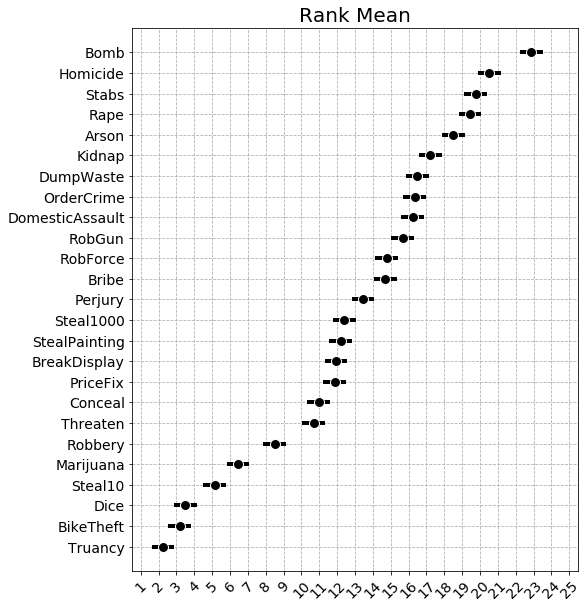

In [4]:
#Get the coefficients in a nice table
table_stats = res.summary2().tables[1]

#Order the table by coef
table_stats.sort_values(by='Coef.', inplace=True)

#Making a bit nicer names
table_stats.reset_index(inplace=True)
table_stats['var_names'] = table_stats['index'].str.split("_", expand=True)[1].str[:-1]
table_stats.drop(columns='index', inplace=True)

#Create error bar length for later ci plot
table_stats['ErrorLen'] = 1.96*table_stats['Std.Err.']

#Now getting the error bar plot
fig, ax = plt.subplots(figsize=(8,10))
ax.errorbar(x='Coef.', y='var_names', xerr='ErrorLen', fmt='o', color='k', elinewidth=4,
            markeredgecolor='w', markersize=10, data=table_stats)
ax.set_title('Rank Mean')
ax.set_xlim(0.5, 25.5)
plt.xticks(range(1,26), rotation=45)
plt.savefig('Coef_Plot.png', dpi=500, bbox_inches='tight')
plt.show()

In [5]:
#Now mapping these to Jerry's harm scores, 
#https://academic.oup.com/policing/article-abstract/9/2/164/1451352
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.701.5217&rep=rep1&type=pdf
#using -1 as missing data
harm_dict = {}
harm_dict['Truancy'] = 1
harm_dict['BikeTheft'] = 2
harm_dict['Dice'] = 1
harm_dict['Steal10'] = 2
harm_dict['Marijuana'] = 3
harm_dict['Robbery'] = 7
harm_dict['Threaten'] = 7
harm_dict['Conceal'] = -1
harm_dict['PriceFix'] = -1
harm_dict['BreakDisplay'] = 7
harm_dict['StealPainting'] = 5
harm_dict['Steal1000'] = 5
harm_dict['Perjury'] = -1
harm_dict['Bribe'] = -1
harm_dict['RobForce'] = 12
harm_dict['RobGun'] = 12
harm_dict['DomesticAssault'] = 11
harm_dict['OrderCrime'] = -1
harm_dict['DumpWaste'] = -1
harm_dict['Kidnap'] = 10
harm_dict['Arson'] = 6
harm_dict['Rape'] = 12
harm_dict['Stabs'] = 14
harm_dict['Homicide'] = 14
harm_dict['Bomb'] = 14

table_stats['HarmScores'] = harm_dict.values()

#Putting mean Wolfgang ranks on a 1-14 scale
table_stats['RankHarm'] = (table_stats['Coef.']/25)*14

table_stats[ ['var_names','HarmScores','RankHarm'] ]

,var_names,HarmScores,RankHarm
0,Truancy,1,1.258343
1,BikeTheft,2,1.779512
2,Dice,1,1.956076
3,Steal10,2,2.878405
4,Marijuana,3,3.610776
5,Robbery,7,4.762368
6,Threaten,7,5.984856
7,Conceal,-1,6.138893
8,PriceFix,-1,6.642339
9,BreakDisplay,7,6.682793


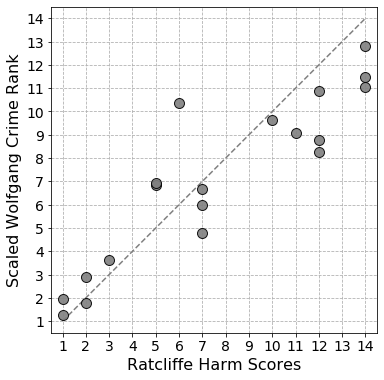

In [6]:
#Now make a nice scatterplot

fig, ax = plt.subplots(figsize=(9,6))
ax.plot([1,14],[1,14],color='grey',linestyle='dashed')
ax.plot(table_stats['HarmScores'], table_stats['RankHarm'], 'o', color='grey',
            markeredgecolor='black', markersize=10, alpha=0.9)
ax.set_xlabel('Ratcliffe Harm Scores')
ax.set_ylabel('Scaled Wolfgang Crime Rank')
ax.set_xlim(0.5, 14.5)
ax.set_ylim(0.5, 14.5)
plt.xticks(range(1,15))
plt.yticks(range(1,15))
ax.set_aspect('equal')
plt.savefig('RankCompare.png', dpi=500, bbox_inches='tight')
plt.show()